In [2]:
import numpy as np
import cv2
import json
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
from sklearn.preprocessing import normalize

In [3]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def plot_images(im1, im2):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    axes[0].imshow(im1, cmap=plt.get_cmap('gray'))
    axes[1].imshow(im2, cmap=plt.get_cmap('gray'))
    fig.tight_layout()
    
def make_color_map(colored):
    gray = rgb2gray(colored)
    m = {}

    for r in range(gray.shape[0]):
        for c in range(gray.shape[1]):
            m[gray[r][c]] = list(colored[r][c])
    
    return sorted(m.items(), key=lambda x: x[0])

def find_nearest(color_map, target):
    f = 0
    l = len(color_map) - 1
    
    while(f <= l):
        mid = (f + l) // 2
        if color_map[mid][0] == target:
            return color_map[mid][1]
        elif target < color_map[mid][0]:
            l = mid - 1
        else:
            f = mid + 1
    
    nearest = None;
    distance = float('inf')
    for i in [f, l]:
        try:
            d = abs(color_map[i][0] - target)
            if d < distance:
                nearest = color_map[i][1]
        except:
            pass
    
    return nearest
    
def sharpen_image(img):
    min = img.min()
    max = img.max()
    
    return (img - min) / (max - min) * 255

def colorize(gray, colored):
    color_map = make_color_map(sharpen_image(colored))
    sharpened_gray = sharpen_image(gray)
    
    result = np.zeros((*gray.shape, 3))

    for r in range(gray.shape[0]):
        for c in range(gray.shape[1]):
            result[r][c] = find_nearest(color_map, sharpened_gray[r][c])
            
    return result

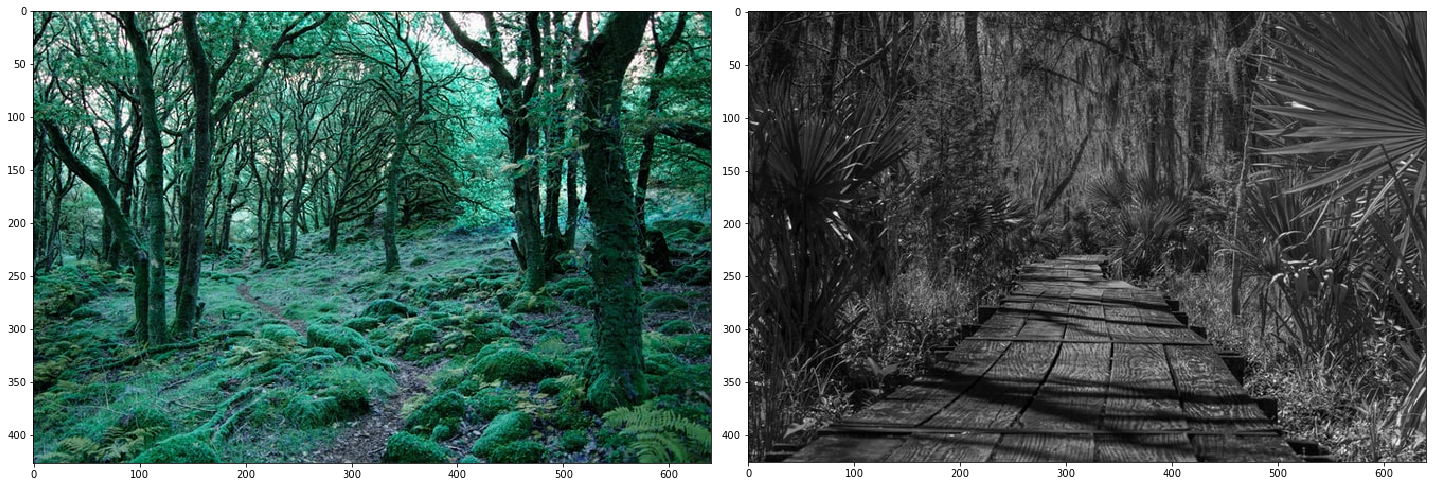

In [4]:
colored_img = cv2.imread('Colored/2.jpg')
gray_img = cv2.imread('Gray/3.jpg', cv2.IMREAD_GRAYSCALE)

plot_images(colored_img, gray_img)

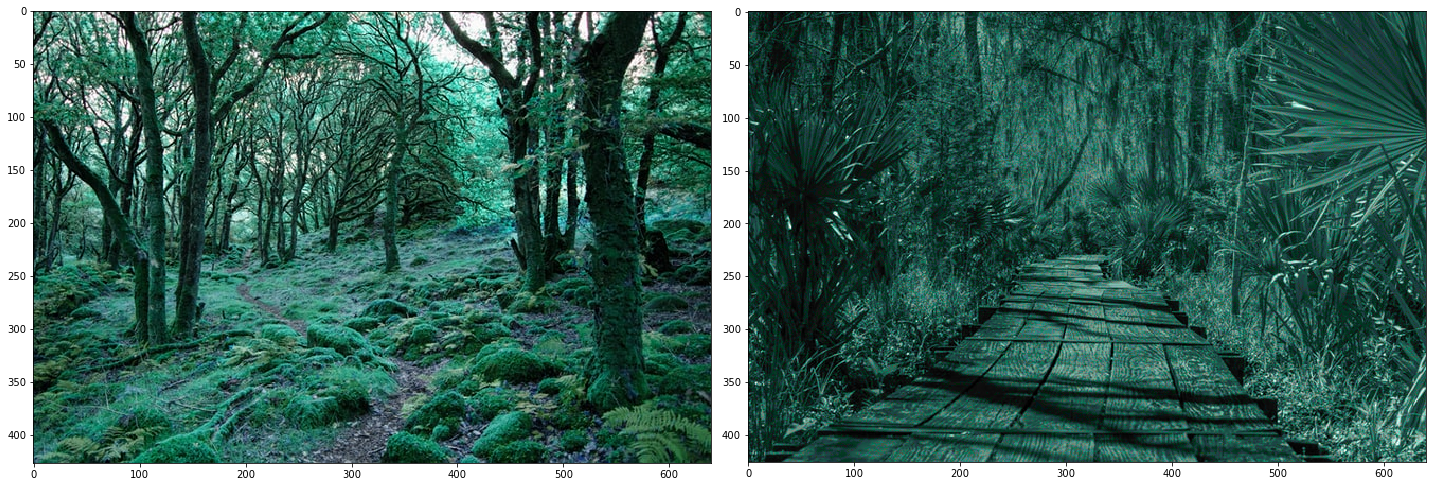

In [5]:
transformed_img = colorize(gray_img, colored_img)
plot_images(colored_img, transformed_img / 255)

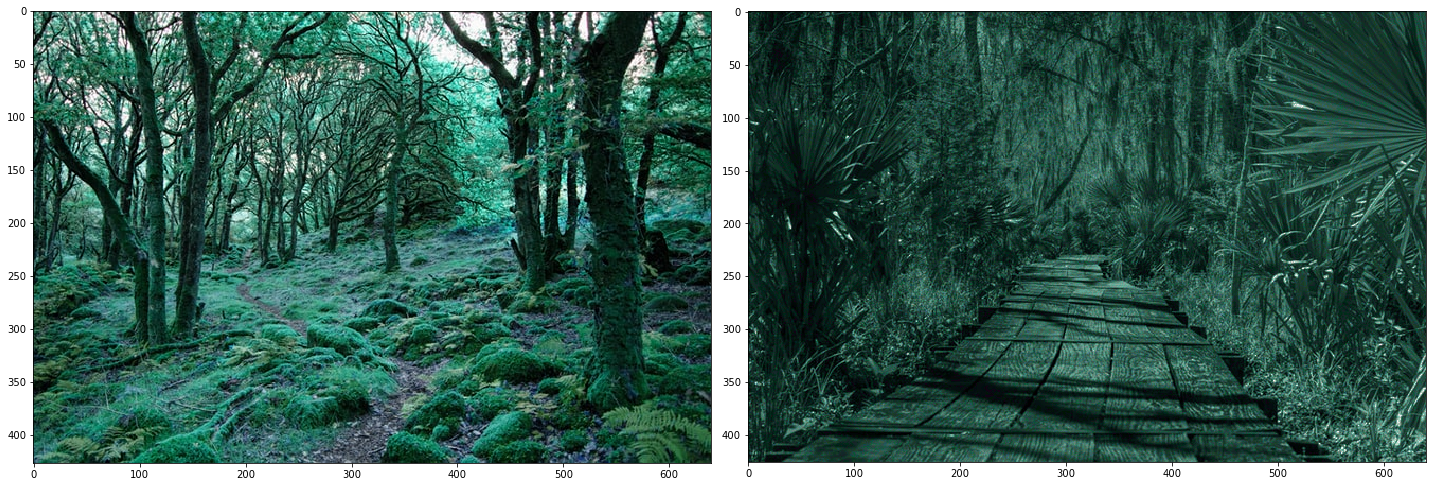

In [7]:
def get_sub_matrix(gray, r, c):
    radius = 3
    
    return gray[min(r - radius, 0): max(r + radius, gray.shape[0]), min(0, c - radius): max(c + radius, gray.shape[1])]

def get_mean_feature(gray, r, c):
    return get_sub_matrix(gray, r, c).mean()

def get_variance_feature(gray, r, c):
    return np.var(get_sub_matrix(gray, r, c))

def extract_features(gray, r, c):
    return normalize([
        gray[r][c], 
        get_mean_feature(gray, r, c),
        get_variance_feature(gray, r, c)
    ])
    
def normalize(l):
    s = sum(l)
    
    return list(map(lambda item: item / s, l))

def make_kdtree_data(img):
    kdtree_data = []
    mapper = dict()
    gray = rgb2gray(img)
    
    for r in range(gray.shape[0]):
        for c in range(gray.shape[1]):
            features = extract_features(gray, r, c)
            kdtree_data.append(features)
            
            mapper[features_encoder(features)] = list(img[r][c])
    
    get_rgb = lambda x: mapper[features_encoder(x)]
    
    return kdtree_data, get_rgb
    
def features_encoder(features):
    return "".join(map(str, list(features)))

def advanced_colorize(target, colored_base):
    kdtree_data, get_rgb = make_kdtree_data(sharpen_image(colored_base))
    kdtree = KDTree(kdtree_data, compact_nodes=False)
    query = lambda x: get_rgb(kdtree.data[kdtree.query(x, workers=-1)[1]])
    
    sharpened_target = sharpen_image(target)
    
    result = np.zeros((*target.shape, 3))

    for r in range(target.shape[0]):
        for c in range(target.shape[1]):
            result[r][c] = query(extract_features(target, r, c))
            
    return result
    
transformed_img = advanced_colorize(gray_img, colored_img)
plot_images(colored_img, transformed_img / 255)